# Trim results to smaller areas

In [2]:
import sys
import os
import folium
import numpy.ma as ma
from folium import Map, FeatureGroup, LayerControl
import rasterio
from shapely.geometry import box
import geopandas as gpd
from pyproj import CRS
from rasterio.mask import mask
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
import rioxarray as rxr
from rasterio import plot
from shapely.geometry import mapping
import glob 

# Define whether to filter out values <0.1
remove_little_values = True

os.chdir('../ProcessModelResults/IdealisedProfiles/')
from my_functions_idealisedprofiles import *
model_directory = '../../../../FloodModelling/'
catchment_name = 'LinDyke'

### Read in the catchment boundary, and the boundaries for Kippax and Garforth

In [3]:
boundaries_gpd_dict={}

# Specify catchment boundary
catchment_gdf = gpd.read_file(model_directory + '{}Models/Model_IdealisedProfiles/CatchmentLinDyke_exported.shp'.format(catchment_name))
boundaries_gpd_dict['LinDyke'] =catchment_gdf

for subcatchment in ['Garforth_East', 'Garforth_West', 'Kippax_West', 'South_Catchment', 'Kippax', 'TB_South', 'TB_North']:
    # Read in boundary
    if subcatchment == 'Kippax':
        all_boundaries = gpd.read_file(model_directory + "SubCatchmentBoundaries/Kippax/Parishes/Parishes_December_2016_FCB_in_England_and_Wales.shp")
        boundary = all_boundaries[all_boundaries['par16nm'] == 'Kippax']
    else:
        boundary = gpd.read_file(model_directory + "SubCatchmentBoundaries/{}/{}.shp".format(subcatchment, subcatchment))
    # Convert projection
    boundary = boundary.to_crs("epsg:27700") 
    # Add to dict
    boundaries_gpd_dict[subcatchment]=boundary

In [114]:
cols_dict = {}
cols = ['black','green', 'orange','purple','yellow','blue','cyan','pink']
for num,key in enumerate(boundaries_gpd_dict.keys()):
    cols_dict[key] =cols[num]

In [69]:
# model_directory = '../../../../FloodModelling/'

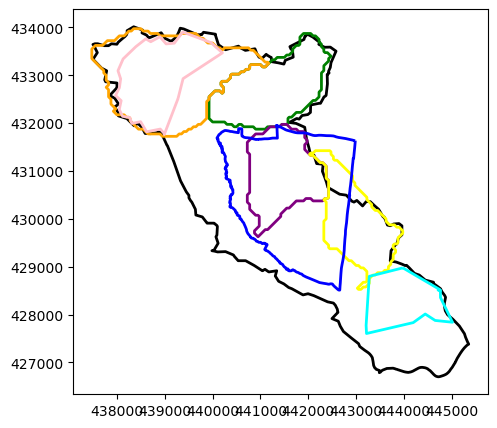

In [121]:
fig, ax =plt.subplots(figsize =(12,5))
for boundary_key, boundary in boundaries_gpd_dict.items():
    boundary.plot(ax=ax, facecolor="none", linewidth=2, edgecolor =cols_dict[boundary_key])

## Trim model results to Garforth/Kippax boundary

### Idealised profiles

In [158]:
methods =[ '6h_sp_c_0.5','6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']

'6h_sp_bl_0.9'

In [5]:
for region_name in ['Garforth_East', 'Garforth_West']:#, 'Kippax_West', 'South_Catchment']:#, 'NW_area', 'Kippax']:
    # Select boundary 
    region_boundary =boundaries_gpd_dict[region_name]     
        
    # Trim for each method        
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + '{}Models/Model_IdealisedProfiles/'.format(catchment_name) + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory  + '{}Models/Model_IdealisedProfiles/'.format(catchment_name) + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + '{}Models/Model_IdealisedProfiles/'.format(catchment_name)+ "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + '{}Models/Model_IdealisedProfiles/'.format(catchment_name)+ method + '/{}/'.format(region_name) + file.split('/')[-1])                   

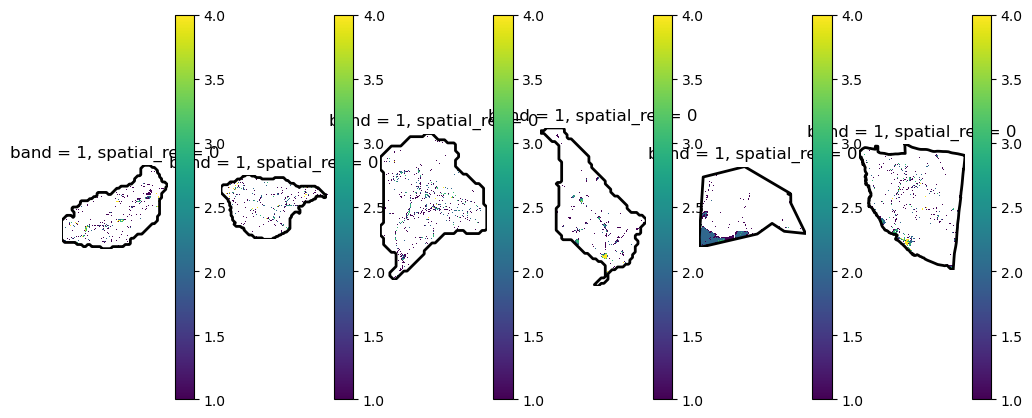

In [4]:
fig, axs =plt.subplots(ncols=6, figsize =(12,5))

for num, region_name in enumerate(['Garforth_East', 'Garforth_West', 'Kippax_West', 'South_Catchment', 'TB_South', 'Kippax']):
    # Select boundary 
    region_boundary =boundaries_gpd_dict[region_name]          
    # Read in data
    raster = rxr.open_rasterio(model_directory + 'LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/{}/Depth_classified.tif'.format(region_name), masked=True).squeeze()
    raster.plot.imshow(ax=axs[num])
    region_boundary.plot(ax=axs[num], facecolor="none", edgecolor= 'black', linewidth=2)
    axs[num].set_axis_off()
    axs[num].legend('', frameon=False)

### Idealised profiles (scaled)

In [6]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles_Scaled/'

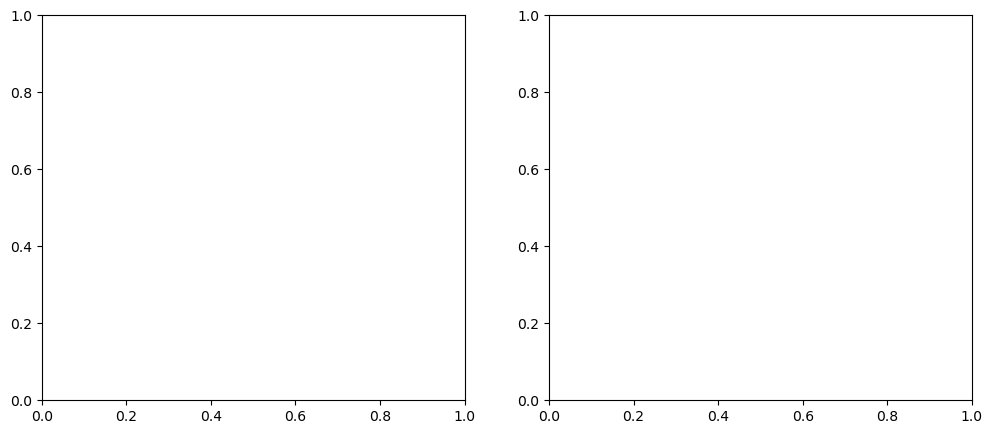

In [7]:
fig, axs =plt.subplots(ncols=2, figsize =(12,5))
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

### Idealised profiles (drier antecedent conditions)

In [44]:
model_directory = '../../../../FloodModelling/Model_IdealisedProfiles_drierConditions/'

In [ ]:
fig, axs =plt.subplots(ncols=2, figsize =(12,5))
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for number, file in enumerate(files):
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

### Observed profiles

In [16]:
model_directory = '../../../../FloodModelling/Model_ObservedProfiles/'

In [17]:
methods = ['6h_feh_singlepeak', '6h_c1','6h_c8','6h_c15','6h_c3','6h_c11','6h_c10','6h_c9','6h_c13','6h_c6',
 '6h_c2','6h_c12','6h_c14','6h_c4','6h_c7','6h_c5']  

In [20]:
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        if method == '6h_feh_singlepeak':
            path = '../../../../FloodModelling/Model_FEHProfiles/{}/{}'.format(method, region_name)
        else:
            path = model_directory + method + '/{}/'.format(region_name)
        # Create subdirectory for outputs
        if not os.path.exists(path):
            os.mkdir(path)
        # Find all files in the directory
        files = glob.glob(path.replace('/{}'.format(region_name), '') + '/'+ '*.tif')
        # Loop through each file and create a filtered version
        for file in files:
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(path + '/' + file.split('/')[-1])    

### Single peak (scaled)

In [ ]:
model_directory = '../../../../FloodModelling/Model_SinglePeak_Scaled/'

In [ ]:
methods = ['6h_sp_+0','6h_sp_+05','6h_sp_+10','6h_sp_+20','6h_sp_+30']  

In [ ]:
for region_name in ['Kippax', 'Garforth']:
    if region_name == 'Kippax':
        region_boundary = kippax_boundary
    elif region_name == 'Garforth':
        region_boundary = garforth_boundary
    
    for method in methods:
        # Create subdirectory for outputs
        if not os.path.exists(model_directory + method + '/{}/'.format(region_name)):
            os.mkdir(model_directory + method + '/{}/'.format(region_name))
        # Find all files in the directory
        path = model_directory + "{}/*.tif".format(method)
        files = glob.glob(path)
        # Loop through each file and create a filtered version
        for file in files:
            raster = rxr.open_rasterio(file, masked=True).squeeze()
            raster_clipped = raster.rio.clip(region_boundary.geometry.apply(mapping),region_boundary.crs)
            raster_clipped.rio.to_raster(model_directory + method + '/{}/'.format(region_name) + file.split('/')[-1])    

## Check locations of cells with the deepest flooding: Idealised Profiles (example)

### Save versions of outputs with cells > certain depth set to nan

In [ ]:
# flooding, out_meta = open_and_clip( '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max).Resampled.Terrain.tif')
# out_meta.update({"nodata":np.nan, "dtype" :'float64' })
# flooding[flooding <2 ] = np.nan
# save_array_as_raster(flooding,  '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan2.Resampled.Terrain.tif', out_meta)

flooding, out_meta = open_and_clip( '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max).Resampled.Terrain.tif')
out_meta.update({"nodata":np.nan, "dtype" :'float64' })
flooding[flooding <1 ] = np.nan
save_array_as_raster(flooding,  '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan1.Resampled.Terrain.tif', out_meta)


flooding, out_meta = open_and_clip( '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max).Resampled.Terrain.tif')
out_meta.update({"nodata":np.nan, "dtype" :'float64' })
flooding[flooding <0.5 ] = np.nan
save_array_as_raster(flooding,  '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan.5.Resampled.Terrain.tif', out_meta)


### Create colourmaps

In [ ]:
labels= ['SubUrban', 'Arable', 'Deciduous woodland', 'Freshwater', 'Improved grassland', 'Urban', 'Neutral grassland', 'Calcareous grassland', 'Heather grassland']
colors = ['darkslategrey', 'khaki', 'darkgreen','darkturquoise','#59F74D', 'slateblue', 'lightgreen', 'palegreen', 'pink']
cmap_classified = mpl.colors.ListedColormap(colors)

colors = ['#97bddb', '#82a2cf', '#6c87c4','#566cb8','#4151ad', '#2b36a2', '#161b96','#00008b']
cmap_flooding = mpl.colors.ListedColormap(colors)

In [15]:
# Set up figure
f = folium.Figure(width=500, height=500)

# Create base map - location figures were from clat, clon, but wanted to create map before loop
mapa = folium.Map(location=[53.768306874761016, -1.3756056884868098],zoom_start=12).add_to(f)
folium.TileLayer(
    tiles = 'https://basemap.nationalmap.gov/arcgis/rest/services/USGSTopo/MapServer/tile/{z}/{y}/{x}',
    attr="No Base Map",
    name="No Base Map",
    show=True
).add_to(mapa)

# Catchment boundary
catchment_boundary_feature_group = FeatureGroup(name='Catchment boundary')
catchment_boundary_feature_group.add_child(folium.GeoJson(data=catchment_gdf["geometry"], style_function=lambda x, 
                                     fillColor='#00000000', color='Black': { "fillColor": '#00000000',"color": 'Black',}))

# Add landcover data
landcover_fps = ['../../../../FloodModelling/LandCoverData/LandCover_clipped.tif',
                '../../../../FloodModelling/LandCoverData/LandCover_water_classification.tif',
                 '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan.5.Resampled.Terrain.tif',
                '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan1.Resampled.Terrain.tif',
                '../../../../FloodModelling/LinDykeModels/Model_IdealisedProfiles/6h_sp_bl_0.9/Depth (Max)_morethan2.Resampled.Terrain.tif']
names = [ 'landcover','Classified', 'Flooding_.5', 'Flooding_1', 'Flooding_2']
for number, landcover_fp in enumerate(landcover_fps):
    xarray_dataarray = prep_for_folium_plotting(landcover_fp)
    # Get coordinates needed in plotting
    clat, clon = xarray_dataarray.y.values.mean(), xarray_dataarray.x.values.mean()
    mlat, mlon = xarray_dataarray.y.values.min(), xarray_dataarray.x.values.min()
    xlat, xlon = xarray_dataarray.y.values.max(), xarray_dataarray.x.values.max()
    # Apply colormap
    data  = ma.masked_invalid(xarray_dataarray.values)
    if 'LandCover' in landcover_fp:
        colored_data = colorize(data.data, cmap=cmap_classified)        
    else:
        colored_data = colorize(data.data, cmap=cmap_classified)
    
    # Add to map
    feature_group1 = FeatureGroup(name=names[number])
    feature_group1.add_child(folium.raster_layers.ImageOverlay(colored_data,
                              [[mlat, mlon], [xlat, xlon]],
                              opacity=0.8,interactive=True, popup=names[number]))
    mapa.add_child(feature_group1)

# Add layers to map
mapa.add_child(catchment_boundary_feature_group)
mapa.add_child(LayerControl("topright", collapsed = False))
display(mapa)